In [10]:
DATA_PATH = '../data/mexico_milk_prices.csv'
SHEET_NAME = None
TARGET = None
ID_COLS = []
FORCE_CATEGORICAL = []
FORCE_NUMERIC = []
SAMPLE_N = 1000
RANDOM_SEED = 42

In [11]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')
np.random.seed(RANDOM_SEED)

pd.options.display.max_columns = 200
pd.options.display.width = 120

def read_data(path):

    return pd.read_csv(path)


def basic_report(df):
    print('Dimensão:', df.shape)
    display(df.head())
    print('\nTipos e não-nulos por coluna:')
    display(pd.DataFrame(df.dtypes, columns=['dtype']))
    print('\nContagem de valores nulos (colunas com >0 nulos):')
    display(df.isna().sum().loc[lambda x: x>0].sort_values(ascending=False))

def summary_statistics(df, numeric_only=True):
    if numeric_only:
        return df.describe().T
    else:
        return df.describe(include='all').T

def resumo_preco_por_categoria(df, var_cat, var_num='Precio'):
    """
    Retorna estatísticas descritivas da variável numérica agrupadas pela categórica.
    """
    resumo = (
        df.groupby(var_cat)[var_num]
        .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
        .sort_values(by='mean', ascending=False)
        .round(2)
    )
    return resumo

def plot_media_por_categoria(df, var_cat, var_num='Precio'):
    resumo = df.groupby(var_cat)[var_num].mean().sort_values()
    plt.figure(figsize=(8,5))
    sns.barplot(x=resumo.values, y=resumo.index, palette='viridis')
    plt.title(f"{var_num} médio por {var_cat}")
    plt.xlabel(f"Média de {var_num}")
    plt.ylabel(var_cat)
    plt.show()

def top_categories(df, col, n=10):
    return df[col].value_counts(dropna=False).head(n)

def sample_if_large(df, n=SAMPLE_N):
    return df.sample(n) if len(df)>n else df.copy()

def plot_hist_box(df, col, bins=30):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[col].dropna(), bins=bins, ax=axes[0], kde=True)
    axes[0].set_title(f'Histograma: {col}')
    sns.boxplot(x=df[col].dropna(), ax=axes[1])
    axes[1].set_title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

def plot_count(df, col):
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Contagem por categoria: {col}')
    plt.show()

def corr_matrix(df, numeric_only=True):
    if numeric_only:
        num = df.select_dtypes(include=[np.number])
    else:
        num = df.copy()
    corr = num.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink':.8})
    plt.title('Matriz de correlação')
    plt.show()

def analyze_target(df, target):
    if target not in df.columns:
        print('Target não encontrada')
        return
    if pd.api.types.is_numeric_dtype(df[target]):
        print('Estatísticas da target numérica:')
        display(df[target].describe())
        plt.figure(figsize=(6,4))
        sns.histplot(df[target].dropna(), kde=True)
        plt.title('Distribuição da target')
        plt.show()
    else:
        print('Contagem por classe da target categórica:')
        display(df[target].value_counts())
        plt.figure(figsize=(6,4))
        sns.countplot(x=target, data=df)
        plt.title('Contagem da target')
        plt.show()

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

In [12]:
df = read_data(DATA_PATH)
df = set_dtypes(df)
print('Dados carregados com sucesso')

basic_report(df)


Dados carregados com sucesso
Dimensão: (52056, 6)


,Fecha,Estado,Ciudad,Tipo,Canal,Precio
0,2025-08-15,Aguascalientes,Aguascalientes,Pasteurizada,Tiendas,27.4
1,2025-08-15,Baja California,Mexicali,Pasteurizada,Tiendas,29.3
2,2025-08-15,Baja California,Tijuana,Pasteurizada,Tiendas,NaN
3,2025-08-15,Baja California Sur,La Paz,Pasteurizada,Tiendas,26.0
4,2025-08-15,Campeche,Campeche,Pasteurizada,Tiendas,NaN



Tipos e não-nulos por coluna:


,dtype
Fecha,object
Estado,object
Ciudad,object
Tipo,object
Canal,object
Precio,float64



Contagem de valores nulos (colunas com >0 nulos):


Precio    6511
dtype: int64

### Estatisticas descritivas - variavel numerica

In [13]:
display(summary_statistics(df[num_cols]))

,count,mean,std,min,25%,50%,75%,max
Precio,45545.0,27.5424,5.18567,0.0,26.0,28.0,29.9,40.0


### Estatisticas descritivas - variavel numerica por categoricas

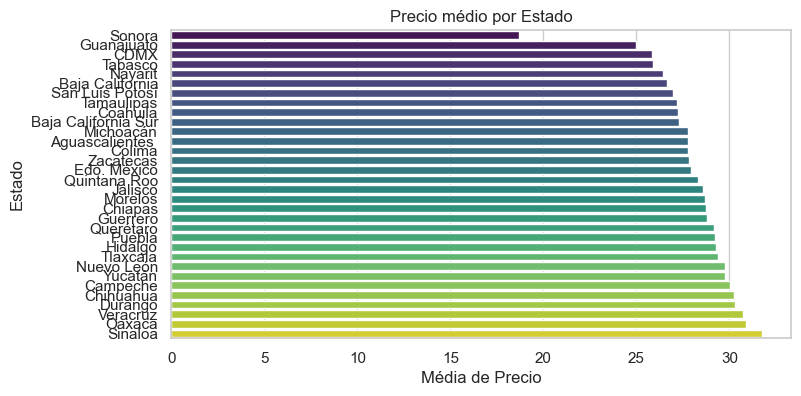

None

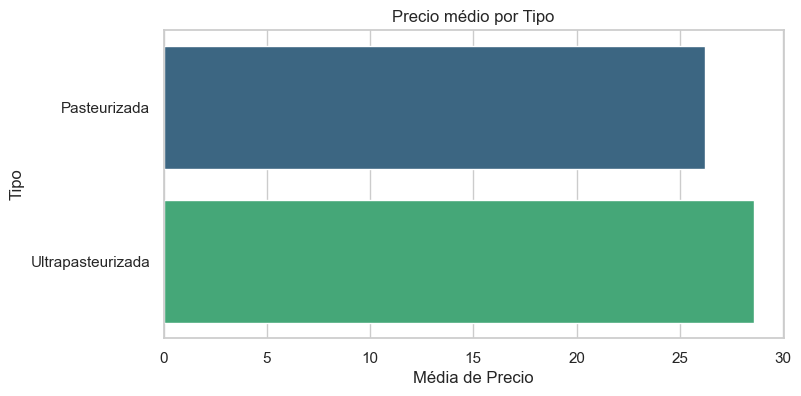

None

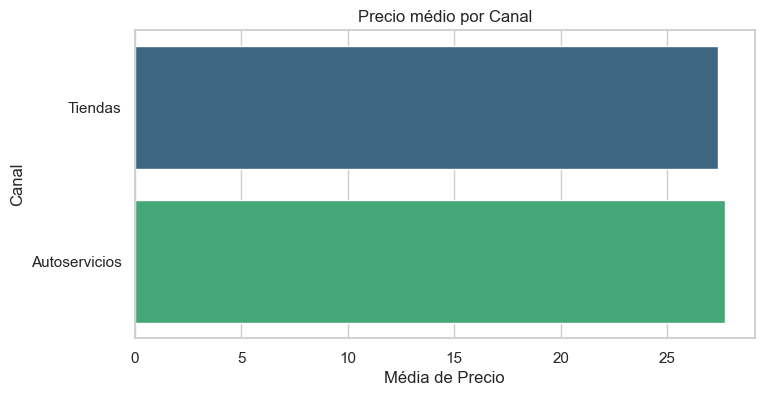

None

In [25]:
display(plot_media_por_categoria(df, 'Estado', 'Precio'))
display(plot_media_por_categoria(df, 'Tipo', 'Precio'))
display(plot_media_por_categoria(df, 'Canal', 'Precio'))

In [22]:
display(resumo_preco_por_categoria(df, 'Estado'))
display(resumo_preco_por_categoria(df, 'Tipo'))
display(resumo_preco_por_categoria(df, 'Canal'))

,count,mean,median,std,min,max
Estado,,,,,,
Sinaloa,964,31.73,31.39,2.80,25.30,37.33
Oaxaca,964,30.91,30.33,1.51,28.97,35.32
Veracruz,1446,30.70,30.63,2.95,24.75,36.35
Durango,1687,30.28,29.45,2.85,25.30,38.95
Chihuahua,1687,30.23,29.29,2.78,25.90,37.72
Campeche,482,30.05,29.07,2.14,27.00,35.40
Yucatán,482,29.77,29.25,1.97,25.45,34.97
Nuevo León,1928,29.75,29.48,3.28,24.33,40.00
Tlaxcala,964,29.39,28.88,3.02,25.25,36.00


,count,mean,median,std,min,max
Tipo,,,,,,
Ultrapasteurizada,25303,28.59,29.03,5.23,0.0,40.0
Pasteurizada,20242,26.23,27.00,4.82,0.0,35.3


,count,mean,median,std,min,max
Canal,,,,,,
Autoservicios,23134,27.72,28.10,5.21,0.0,37.9
Tiendas,22411,27.36,27.98,5.16,0.0,40.0


In [ ]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['category','object','bool']).columns.tolist()
# remover id cols e target das listas se presentes
num_cols = [c for c in num_cols if c not in ID_COLS]
cat_cols = [c for c in cat_cols if c not in ID_COLS]
if TARGET:
    num_cols = [c for c in num_cols if c != TARGET]
    cat_cols = [c for c in cat_cols if c != TARGET]

print('Colunas numéricas:', num_cols)
print('Colunas categóricas:', cat_cols)

# %%
# Estatísticas descritivas numéricas


# Estatísticas para categóricas (top categories)
for c in cat_cols:
    print('\nColuna categórica:', c)
    display(top_categories(df, c, n=10))

# %%
# Valores faltantes
miss = df.isna().sum().sort_values(ascending=False)
miss = miss[miss>0]
display(miss)
if len(miss)>0:
    pct = (miss / len(df) * 100).round(2)
    display(pd.concat([miss, pct], axis=1, keys=['missing_count','missing_pct']))

# %%
# Visualizações univariadas automáticas (numéricas): histogramas e boxplots
for c in num_cols:
    try:
        print('\n==', c)
        plot_hist_box(df, c)
    except Exception as e:
        print('Erro ao plotar', c, e)

# %%
# Visualizações categóricas (top categories)
for c in cat_cols:
    try:
        print('\n==', c)
        plot_count(df, c)
    except Exception as e:
        print('Erro ao plotar', c, e)

# %%
# Matriz de correlação (entre numéricas)
if len(num_cols) > 1:
    corr_matrix(df[num_cols])
else:
    print('Poucas colunas numéricas para correlação')

# %%
# Análise da target (se informada)
if TARGET:
    analyze_target(df, TARGET)
else:
    print('TARGET não informada; defina TARGET na configuração para esta seção')

# %%
# Tratamento rápido de missing (exemplo) e codificação simples
def quick_impute_and_encode(df, numeric_strategy='median', fill_categorical='missing'):
    df_proc = df.copy()
    num = df_proc.select_dtypes(include=[np.number]).columns.tolist()
    cat = df_proc.select_dtypes(include=['object','category','bool']).columns.tolist()
    # Impute numéricos
    if num:
        imp_num = SimpleImputer(strategy=numeric_strategy)
        df_proc[num] = imp_num.fit_transform(df_proc[num])
    # Impute categóricos
    for c in cat:
        df_proc[c] = df_proc[c].fillna(fill_categorical)
        if df_proc[c].nunique() < 50:
            df_proc[c] = df_proc[c].astype('category')
    # One-hot para categóricas com poucas categorias
    small_cat = [c for c in cat if df_proc[c].nunique()<=10]
    if small_cat:
        df_proc = pd.get_dummies(df_proc, columns=small_cat, drop_first=True)
    return df_proc

df_proc = quick_impute_and_encode(df)
print('Dataset após imputação/encodificação rápida:', df_proc.shape)

# %%
# Detecção de outliers (IQR) em todas as numéricas
outliers = {c: detect_outliers_iqr(df[c].dropna()) for c in num_cols}
for c, series in outliers.items():
    if len(series)>0:
        print(f'Outliers detectados em {c}: {len(series)} valores')

# %%
# Split rápido em treino/teste (se target informada)
if TARGET and TARGET in df_proc.columns:
    X = df_proc.drop(columns=[TARGET]+ID_COLS if ID_COLS else [TARGET])
    y = df_proc[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    print('Tamanho treino/teste:', X_train.shape, X_test.shape)
else:
    print('Puleu split: TARGET não informada ou não encontrada no dataset processado')
